In [1]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import MaxPooling2D, Conv2D, Flatten, Dense

In [2]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2022-02-02 08:10:51--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.35.76.84, 2600:1407:b800:2a5::e59, 2600:1407:b800:293::e59, ...
Connecting to download.microsoft.com (download.microsoft.com)|23.35.76.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M  97.7MB/s    in 7.6s    

2022-02-02 08:10:58 (104 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [3]:
source_path = '/tmp/PetImages'

source_path_dogs = os.path.join(source_path, 'Dog')
source_path_cats = os.path.join(source_path, 'Cat')

print(f"There are {len(os.listdir(source_path_dogs))} images of dogs.")
print(f"There are {len(os.listdir(source_path_cats))} images of cats.")

There are 12501 images of dogs.
There are 12501 images of cats.


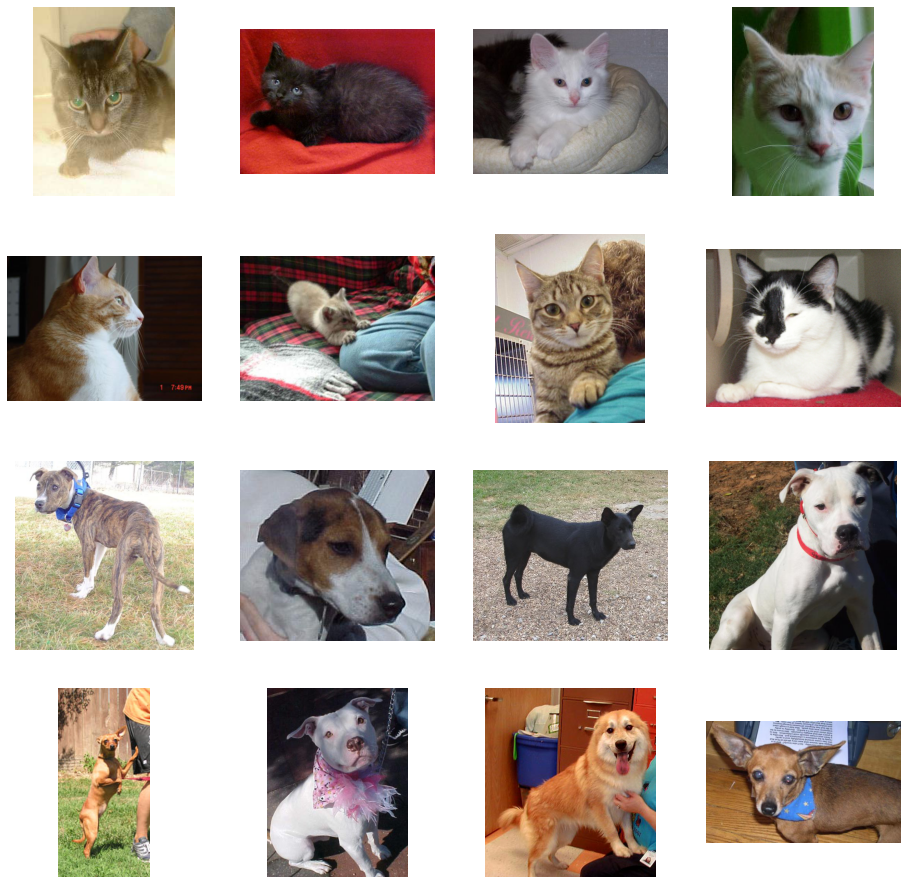

In [4]:
fig = plt.gcf()
fig.set_size_inches(16, 16)

train_cat_fnames = os.listdir(source_path_cats)
train_dog_fnames = os.listdir(source_path_dogs)

next_cat_pix = [os.path.join(source_path_cats, fname) 
                for fname in train_cat_fnames[0:8] 
               ]

next_dog_pix = [os.path.join(source_path_dogs, fname) 
                for fname in train_dog_fnames[0:8]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  sp = plt.subplot(4, 4, i + 1)
  sp.axis('Off')

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [5]:
root_dir = '/tmp/cats-v-dogs'

if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

def create_train_test_dirs(root_path):
  os.makedirs(os.path.join(root_path, 'training/', 'cats'))
  os.makedirs(os.path.join(root_path, 'training/', 'dogs'))
  os.makedirs(os.path.join(root_path, 'testing/', 'cats'))
  os.makedirs(os.path.join(root_path, 'testing/', 'dogs'))
  
try:
  create_train_test_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [6]:
for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/tmp/cats-v-dogs/testing
/tmp/cats-v-dogs/training
/tmp/cats-v-dogs/testing/dogs
/tmp/cats-v-dogs/testing/cats
/tmp/cats-v-dogs/training/dogs
/tmp/cats-v-dogs/training/cats


In [7]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
  temp = os.listdir(SOURCE)
  fnames = []

  for fname in temp:
    if os.path.getsize(os.path.join(SOURCE, fname)) > 0:
        fnames.append(fname)
    else:
      print(f'{fname} is zero length, so ignoring')
  
  nfiles = len(fnames)
  ntrain = int(SPLIT_SIZE * nfiles)
  nest = nfiles - ntrain 

  fnames = random.sample(fnames, nfiles)

  for fname in fnames[:ntrain]:
    path = os.path.join(SOURCE, fname)
    dst_path = os.path.join(TRAINING, fname)
    copyfile(path, dst_path)

  for fname in fnames[ntrain:]:
    path = os.path.join(SOURCE, fname)
    dst_path = os.path.join(TESTING, fname)
    copyfile(path, dst_path)

In [8]:
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
TESTING_DIR = "/tmp/cats-v-dogs/testing/"

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/")
TESTING_CATS_DIR = os.path.join(TESTING_DIR, "cats/")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/")
TESTING_DOGS_DIR = os.path.join(TESTING_DIR, "dogs/")

if len(os.listdir(TRAINING_CATS_DIR)) > 0:
  for file in os.scandir(TRAINING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_DOGS_DIR)) > 0:
  for file in os.scandir(TRAINING_DOGS_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_CATS_DIR)) > 0:
  for file in os.scandir(TESTING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_DOGS_DIR)) > 0:
  for file in os.scandir(TESTING_DOGS_DIR):
    os.remove(file.path)

split_size = .9

split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

print(f"\n\nThere are {len(os.listdir(TRAINING_CATS_DIR))} images of cats for training")
print(f"There are {len(os.listdir(TRAINING_DOGS_DIR))} images of dogs for training")
print(f"There are {len(os.listdir(TESTING_CATS_DIR))} images of cats for testing")
print(f"There are {len(os.listdir(TESTING_DOGS_DIR))} images of dogs for testing")

666.jpg is zero length, so ignoring
11702.jpg is zero length, so ignoring


There are 11250 images of cats for training
There are 11250 images of dogs for training
There are 1250 images of cats for testing
There are 1250 images of dogs for testing


In [9]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                     rotation_range=60,
                                     width_shift_range=0.3,
                                     height_shift_range=0.3,
                                     shear_range=0.3,
                                     zoom_range=0.5,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=100,
                                                      class_mode='binary',
                                                      target_size=(150, 150))

  validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=10,
                                                                class_mode='binary',
                                                                target_size=(150, 150))

  return train_generator, validation_generator

In [10]:
train_generator, validation_generator = train_val_generators(TRAINING_DIR, TESTING_DIR)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [11]:
def create_model():
  model = tf.keras.models.Sequential([ 
      Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
      MaxPooling2D(2,2),
      Conv2D(64, (3,3), activation='relu'),
      MaxPooling2D(2,2),
      Conv2D(128, (3,3), activation='relu'),
      MaxPooling2D(2,2),
      Conv2D(128, (3,3), activation='relu'),
      MaxPooling2D(2,2),
      Flatten(),
      Dense(512, activation='relu'),
      Dense(1, activation='sigmoid')
  ])
  
  model.compile(optimizer=RMSprop(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy']) 
    
  return model


In [12]:
model = create_model()

history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/15
193/225 [========================>.....] - ETA: 26s - loss: 0.7242 - accuracy: 0.5527

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

225/225 [==============================] - 208s 876ms/step - loss: 0.7167 - accuracy: 0.5588 - val_loss: 0.6457 - val_accuracy: 0.6320
Epoch 2/15
225/225 [==============================] - 193s 856ms/step - loss: 0.6551 - accuracy: 0.6151 - val_loss: 0.6626 - val_accuracy: 0.5972
Epoch 3/15
225/225 [==============================] - 192s 852ms/step - loss: 0.6314 - accuracy: 0.6435 - val_loss: 0.5365 - val_accuracy: 0.7300
Epoch 4/15
225/225 [==============================] - 192s 852ms/step - loss: 0.6141 - accuracy: 0.6687 - val_loss: 0.6457 - val_accuracy: 0.5844
Epoch 5/15
225/225 [==============================] - 191s 848ms/step - loss: 0.5966 - accuracy: 0.6821 - val_loss: 0.5147 - val_accuracy: 0.7576
Epoch 6/15
225/225 [==============================] - 192s 851ms/step - loss: 0.5815 - accuracy: 0.6942 - val_loss: 0.6517 - val_accuracy: 0.6400
Epoch 7/15
225/225 [==============================] - 196s 870ms/step - loss: 0.5695 - accuracy: 0.7071 - val_loss: 0.4809 - val_accura

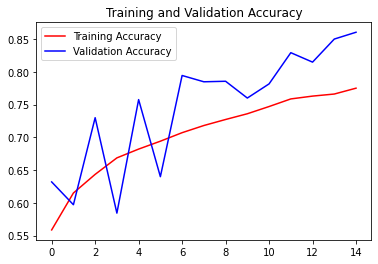

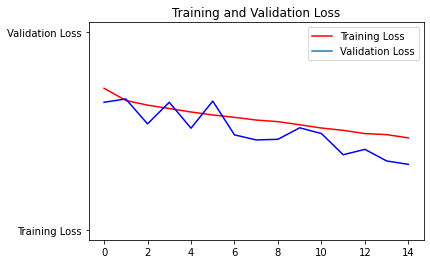

In [13]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) 

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.title('Training and Validation Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()